<a href="https://colab.research.google.com/github/kmin0528/Dacon_Contest/blob/main/Dacon_Car_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dacon 자동차 가격 예측 대회

### 1. 라이브러리 Load 및 설치

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (9,131 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123069 files and di

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.9 MB/s eta 0:00:00


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from keras.utils import to_categorical

In [ ]:
# 변수 중요도 plot
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.rc('font', family='NanumBarunGothic')
    plt.grid()

    return fi_df

In [ ]:
# optuna 모듈로 정의
def objective(trial):

    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 4000, 25000),
        'od_wait':trial.suggest_int('od_wait', 500, 2300),
        'learning_rate' : trial.suggest_float('learning_rate',0.01, 1),
        'reg_lambda': trial.suggest_float('reg_lambda',1e-5,100),
        'subsample': trial.suggest_float('subsample',0,1),
        'random_strength': trial.suggest_float('random_strength',10,50),
        'depth': trial.suggest_int('depth',1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_float('bagging_temperature', 0.01, 100.00,log=True),
        'colsample_bylevel':trial.suggest_float('colsample_bylevel', 0.4, 1.0),
    }

    # Generate model
    model_cbrm = CatBoostRegressor(**cbrm_param)
    model_cbrm = model_cbrm.fit(x_train, y_train, eval_set=[(x_test, y_test)],
                           verbose=0, early_stopping_rounds=25)

	# 평가지표 원하는 평가 지표가 있을 시 바꾸어 준다.
    MSE = mean_squared_error(y_test, model_cbrm.predict(x_test))
    return MSE

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/open (2)/open 3/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/open (2)/open 3/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/open (2)/open 3/sample_submission.csv")

####train 데이터 살펴보기

In [ ]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57920 entries, 0 to 57919
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           57920 non-null  object 
 1   생산년도         57920 non-null  int64  
 2   모델출시년도       57920 non-null  int64  
 3   브랜드          57920 non-null  object 
 4   차량모델명        57920 non-null  object 
 5   판매도시         57920 non-null  object 
 6   판매구역         57920 non-null  object 
 7   주행거리         57920 non-null  int64  
 8   배기량          57920 non-null  int64  
 9   압축천연가스(CNG)  57920 non-null  int64  
 10  경유           57920 non-null  int64  
 11  가솔린          57920 non-null  int64  
 12  하이브리드        57920 non-null  int64  
 13  액화석유가스(LPG)  57920 non-null  int64  
 14  가격           57920 non-null  float64
dtypes: float64(1), int64(9), object(5)
memory usage: 6.6+ MB
None


In [ ]:
train_df.head(5)

,ID,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격
0,TRAIN_00000,2018,2014,skoda,fabia,KAT,SLA,85231,999,0,0,1,0,0,51.74
1,TRAIN_00001,2010,2006,toyota,auris,RKO,SWI,135000,1598,0,0,1,0,0,41.47
2,TRAIN_00002,2002,2002,mercedes-benz,clk-klasa,GNI,WIE,255223,1796,0,0,1,0,0,17.81
3,TRAIN_00003,2006,2001,nissan,x-trail,EHX,WIE,238000,2184,0,1,0,0,0,18.20
4,TRAIN_00004,2007,2007,fiat,bravo,OSW,MAL,251000,1910,0,1,0,0,0,17.55


In [ ]:
train_df.describe()

,생산년도,모델출시년도,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격
count,57920.000000,57920.000000,5.792000e+04,57920.000000,57920.000000,57920.000000,57920.000000,57920.000000,57920.000000,57920.000000
mean,2011.355352,2008.033408,1.678691e+05,1788.160135,0.000483,0.425242,0.517956,0.010290,0.046029,52.211752
std,5.174108,5.087963,8.319120e+04,545.413818,0.021982,0.494384,0.499682,0.100918,0.209550,35.399718
min,1978.000000,1983.000000,1.000000e+00,875.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.170000
25%,2008.000000,2004.000000,1.114345e+05,1461.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.570000
50%,2011.000000,2008.000000,1.710000e+05,1753.000000,0.000000,0.000000,1.000000,0.000000,0.000000,42.250000
75%,2016.000000,2012.000000,2.200000e+05,1995.000000,0.000000,1.000000,1.000000,0.000000,0.000000,73.970000
max,2022.000000,2021.000000,2.500000e+06,6300.000000,1.000000,1.000000,1.000000,1.000000,1.000000,156.000000


In [ ]:
train_df.isna().sum()

ID             0
생산년도           0
모델출시년도         0
브랜드            0
차량모델명          0
판매도시           0
판매구역           0
주행거리           0
배기량            0
압축천연가스(CNG)    0
경유             0
가솔린            0
하이브리드          0
액화석유가스(LPG)    0
가격             0
dtype: int64

In [ ]:
plt.rc('font', family='Nanum Gothic')
sns.set(font="NanumBarunGothic",#"NanumGothicCoding",
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

In [ ]:
train = train_df.copy()
train.drop(columns = "ID",inplace = True)

In [ ]:
# to categorical

## 2. train_data 상관관계

<ipython-input-48-f0ea1a575216>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(),annot = True, fmt= ".3f",annot_kws={'size' : 8}, cmap = "PiYG")


<Axes: >

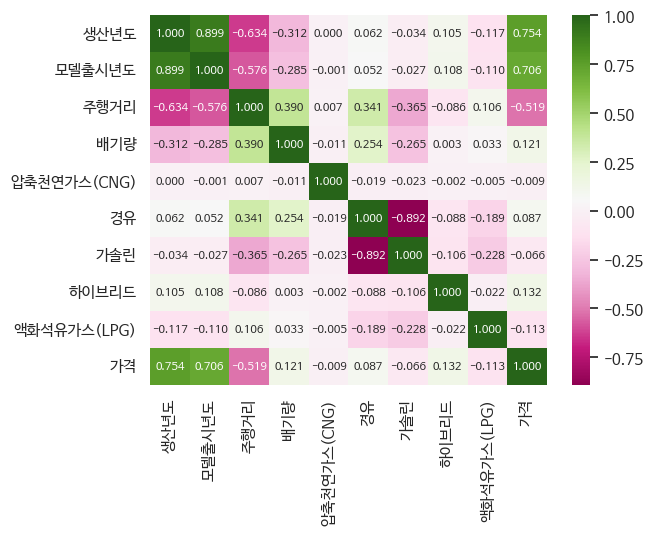

In [ ]:
sns.heatmap(train_df.corr(),annot = True, fmt= ".3f",annot_kws={'size' : 8}, cmap = "PiYG")

In [ ]:
plt.boxplot()

In [ ]:
# train["브랜드"].value_counts() => 20
# train["차량모델명"].value_counts() => 143
# train["판매도시"].value_counts() => 3224
# train["판매구역"].value_counts() => 17

17

In [ ]:
train.drop(columns = ["판매도시","압축천연가스(CNG)","액화석유가스(LPG)","하이브리드"],inplace = True)

In [ ]:
train = train.loc[train["차량모델명"]!="g-klasa"]
train = train.loc[train["차량모델명"]!="gle-klasa"]

In [ ]:
train = pd.get_dummies(train, columns = ["브랜드","차량모델명","판매구역"])
train.columns

Index(['생산년도', '모델출시년도', '주행거리', '배기량', '경유', '가솔린', '가격', '브랜드_audi',
       '브랜드_bmw', '브랜드_citroen',
       ...
       '판매구역_MOR', '판매구역_OPO', '판매구역_POD', '판매구역_POL', '판매구역_POM', '판매구역_SLA',
       '판매구역_SWI', '판매구역_WAR', '판매구역_WIE', '판매구역_ZAC'],
      dtype='object', length=185)

In [ ]:
car1= sorted(train["차량모델명"].unique())
car1

['2',
 '3',
 '3008',
 '5',
 '5008',
 '6',
 '80',
 'a-klasa',
 'a3',
 'a4',
 'a5',
 'a6',
 'a6-allroad',
 'a7',
 'a8',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'astra',
 'auris',
 'avensis',
 'aygo',
 'b-klasa',
 'berlingo',
 'bravo',
 'c-klasa',
 'c-max',
 'c4-picasso',
 'c5',
 'caddy',
 'carens',
 'ceed',
 'civic',
 'cl-klasa',
 'clio',
 'clk-klasa',
 'cls-klasa',
 'colt',
 'combo',
 'corolla',
 'corsa',
 'cr-v',
 'doblo',
 'e-klasa',
 'elantra',
 'espace',
 'fabia',
 'fiesta',
 'focus',
 'frontera',
 'galaxy',
 'gl-klasa',
 'golf',
 'grand-scenic',
 'hr-v',
 'i10',
 'i20',
 'i30',
 'ibiza',
 'insignia',
 'jazz',
 'jetta',
 'juke',
 'ka',
 'kangoo',
 'kuga',
 'laguna',
 'lancer',
 'land-cruiser',
 'leon',
 'm-klasa',
 'megane',
 'meriva',
 'micra',
 'mondeo',
 'note',
 'octavia',
 'omega',
 'outlander',
 'panda',
 'partner',
 'passat',
 'patrol',
 'picanto',
 'polo',
 'primera',
 'prius',
 'punto',
 'q5',
 'q7',
 'qashqai',
 'rav4',
 's-klasa',
 's-max',
 's3',
 's40',
 's60',
 '

In [ ]:
car2= sorted(test_df["차량모델명"].unique())
car2

['2',
 '3',
 '3008',
 '5',
 '5008',
 '6',
 '80',
 'a-klasa',
 'a3',
 'a4',
 'a5',
 'a6',
 'a6-allroad',
 'a7',
 'a8',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'astra',
 'auris',
 'avensis',
 'aygo',
 'b-klasa',
 'berlingo',
 'bravo',
 'c-klasa',
 'c-max',
 'c4-picasso',
 'c5',
 'caddy',
 'carens',
 'ceed',
 'civic',
 'cl-klasa',
 'clio',
 'clk-klasa',
 'cls-klasa',
 'colt',
 'combo',
 'corolla',
 'corsa',
 'cr-v',
 'doblo',
 'e-klasa',
 'elantra',
 'espace',
 'fabia',
 'fiesta',
 'focus',
 'frontera',
 'galaxy',
 'gl-klasa',
 'golf',
 'grand-scenic',
 'hr-v',
 'i10',
 'i20',
 'i30',
 'ibiza',
 'insignia',
 'jazz',
 'jetta',
 'juke',
 'ka',
 'kangoo',
 'kuga',
 'laguna',
 'lancer',
 'land-cruiser',
 'leon',
 'm-klasa',
 'megane',
 'meriva',
 'micra',
 'mondeo',
 'note',
 'octavia',
 'omega',
 'outlander',
 'panda',
 'partner',
 'passat',
 'patrol',
 'picanto',
 'polo',
 'primera',
 'prius',
 'punto',
 'q5',
 'q7',
 'qashqai',
 'rav4',
 's-klasa',
 's-max',
 's3',
 's40',
 's60',
 '

In [ ]:
set(car1) - set(car2)

set()

## 3. ML 모델링

In [ ]:
train.head(4)

,생산년도,모델출시년도,주행거리,배기량,경유,가솔린,가격,브랜드_audi,브랜드_bmw,브랜드_citroen,...,판매구역_MOR,판매구역_OPO,판매구역_POD,판매구역_POL,판매구역_POM,판매구역_SLA,판매구역_SWI,판매구역_WAR,판매구역_WIE,판매구역_ZAC
0,2018,2014,85231,999,0,1,51.74,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2010,2006,135000,1598,0,1,41.47,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2002,2002,255223,1796,0,1,17.81,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2006,2001,238000,2184,1,0,18.20,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
train.columns

Index(['생산년도', '모델출시년도', '주행거리', '배기량', '경유', '가솔린', '가격', '브랜드_audi',
       '브랜드_bmw', '브랜드_citroen',
       ...
       '판매구역_MOR', '판매구역_OPO', '판매구역_POD', '판매구역_POL', '판매구역_POM', '판매구역_SLA',
       '판매구역_SWI', '판매구역_WAR', '판매구역_WIE', '판매구역_ZAC'],
      dtype='object', length=185)

In [ ]:
y = train["가격"]
x = train.drop(columns = ["가격"])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state= 42)

In [ ]:
model = XGBRegressor(eval_metric = "mae")
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
pred = model.predict(x_test)

print(mean_absolute_error(y_test,pred))

6.335182465011353


In [ ]:
# catboost

model_cb = CatBoostRegressor(eval_metric="MAE")
model_cb.fit(x_train,y_train)

Learning rate set to 0.07349
0:	learn: 27.3678301	total: 23.5ms	remaining: 23.4s
1:	learn: 25.8532408	total: 36.4ms	remaining: 18.2s
2:	learn: 24.4534988	total: 55.2ms	remaining: 18.3s
3:	learn: 23.1670616	total: 74.4ms	remaining: 18.5s
4:	learn: 22.0044860	total: 92.9ms	remaining: 18.5s
5:	learn: 20.9655006	total: 115ms	remaining: 19.1s
6:	learn: 20.0140887	total: 134ms	remaining: 19s
7:	learn: 19.1434743	total: 160ms	remaining: 19.9s
8:	learn: 18.3549470	total: 172ms	remaining: 18.9s
9:	learn: 17.6126086	total: 184ms	remaining: 18.2s
10:	learn: 16.9343745	total: 199ms	remaining: 17.9s
11:	learn: 16.3197670	total: 211ms	remaining: 17.4s
12:	learn: 15.7681672	total: 221ms	remaining: 16.8s
13:	learn: 15.2617251	total: 243ms	remaining: 17.1s
14:	learn: 14.8034951	total: 261ms	remaining: 17.1s
15:	learn: 14.3656273	total: 272ms	remaining: 16.7s
16:	learn: 13.9732654	total: 290ms	remaining: 16.8s
17:	learn: 13.6363122	total: 298ms	remaining: 16.3s
18:	learn: 13.3316468	total: 306ms	remaini

###3-1. optuna를 활용한 catboost 하이퍼파라미퍼튜닝

In [ ]:
import optuna
from optuna.samplers import TPESampler

optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=42)
study = optuna.create_study(study_name="catboost", direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=50)

In [ ]:
cb_trial = study.best_trial
cb_trial_params = cb_trial.params
print('Best Trial: score {},\nparams {}'.format(cb_trial.value, cb_trial_params))

Best Trial: score 78.41708858000275,
params {'iterations': 17807, 'od_wait': 561, 'learning_rate': 0.010664926105341317, 'reg_lambda': 40.21640630837588, 'subsample': 0.34744142980980813, 'random_strength': 37.56485295527371, 'depth': 8, 'min_data_in_leaf': 9, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.2663581248461902, 'colsample_bylevel': 0.5392639843065876}


In [ ]:
cb_trial_params

{'iterations': 17807,
 'od_wait': 561,
 'learning_rate': 0.010664926105341317,
 'reg_lambda': 40.21640630837588,
 'subsample': 0.34744142980980813,
 'random_strength': 37.56485295527371,
 'depth': 8,
 'min_data_in_leaf': 9,
 'leaf_estimation_iterations': 5,
 'bagging_temperature': 0.2663581248461902,
 'colsample_bylevel': 0.5392639843065876}

In [ ]:
model = CatBoostRegressor(**cb_trial.params, verbose=False)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [ ]:
print(mean_squared_error(y_test,y_pred))

77.74602718562207


In [ ]:
pred_cb = model_cb.predict(x_test)

print(mean_absolute_error(y_test,pred_cb))8

6.055703477761025


## 4. test data

In [ ]:
test_df.head()

,ID,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG)
0,TEST_00000,2017,2013,mazda,3,KAL,WIE,57000,1998,0,0,1,0,0
1,TEST_00001,2011,2008,ford,fiesta,ROP,POD,159000,1242,0,0,1,0,0
2,TEST_00002,2019,2017,volkswagen,polo,LOD,LOD,11284,999,0,0,1,0,0
3,TEST_00003,2021,2016,renault,megane,JAW,SLA,9,1332,0,0,1,0,0
4,TEST_00004,2010,2011,volvo,v60,WEJ,POM,270000,1999,0,0,1,0,0


In [ ]:
test_df.drop(columns = ["ID","판매도시","압축천연가스(CNG)","하이브리드","액화석유가스(LPG)"],inplace = True)
test_df = pd.get_dummies(test_df, columns = ["브랜드","차량모델명","판매구역"])

In [ ]:
result = model.predict(test_df)
result

array([ 89.69078121,  26.42789928,  88.51207393, ..., 104.04920977,
        49.75411922,  42.98296915])

In [ ]:
submission.head(5)

,ID,가격
0,TEST_00000,0
1,TEST_00001,0
2,TEST_00002,0
3,TEST_00003,0
4,TEST_00004,0


In [ ]:
submission["가격"] = result
submission

,ID,가격
0,TEST_00000,89.690781
1,TEST_00001,26.427899
2,TEST_00002,88.512074
3,TEST_00003,128.442747
4,TEST_00004,48.568275
...,...,...
14475,TEST_14475,43.979732
14476,TEST_14476,23.544276
14477,TEST_14477,104.049210
14478,TEST_14478,49.754119


In [ ]:
submission.to_csv("catboost_optuna.csv",index = False)